Source: http://www.rpgroup.caltech.edu/bige105/2018/code/t02_sequence_analysis_biogeography.html

In [15]:
import Bio.SeqIO
import Bio.AlignIO
import Bio.Phylo
import numpy as np
import pandas as pd

In [27]:
def compute_similarity(seq_1, seq_2):
    """
    Computes the percent similarity between two sequences ignoring gaps. 
    
    Parameters
    ----------
    seq_1, seq_2 : strings
        DNA sequences to compare. These must be the same length.
        
    Returns
    -------
    score : float
        The percent similarity between the two sequences. 
    """
    # Make sure they are the same length. 
    if len(seq_1) != len(seq_2):
        raise ValueError('Sequences must be the same length!')
        
    # Make both sequences lowercase.
    seq_1 = seq_1.lower()
    seq_2 = seq_2.lower()
        
    # Set up counters of length and similarity.
    comp_length = 0
    num_sim = 0
    
    # Iterate through each position in the sequences.
    for base in range(len(seq_1)):
        
        # Ensure we are not comparing gaps.
        if (seq_1[base] != '-') and (seq_2[base] != '-'):
            
            # Increase the counter for compared length.
            comp_length += 1
            
            # Compare the two positions.
            if seq_1[base] == seq_2[base]:
                
                # Increase the similarity counter.
                num_sim += 1
                
    # Compute and return the percent similarity.
    score = num_sim  / comp_length
    return score


def s_matrix(mat):
    '''
    Computes the S-Matrix for the Neighbor Joining algorithm. Each entry
    S_ij computes the total branch length assuming that nodes i and j form
    a new OTU.
    Parameters
    ----------
    mat : array-like. N x N matrix
        Square matrix containing similarity scores between OTUs
    Returns
    -------
    s_mat : array-like. N x N matrix
        Square matrix containing the total branch length when joining
        each possible pair of OTUs
    '''
    # Get the number of entries in matrix
    n = len(mat)
    
    # Compute the starlike length
    s_star = 1 / (n - 1) * np.sum(np.triu(mat))
    # Initialize matrix to save entries
    s_mat = np.ones_like(mat) * s_star

    # Loop through rows
    for i in range(n):
        # Loop through columns
        for j in range(n):
            # Define list of index different from i and j
            idx_out = np.arange(n)
            idx_out = np.delete(idx_out, [i, j])
            
            # To make the calculation simpler we will divide Eq. 3 into
            # the three terms
            # First term
            first_term = 1 / (2 * (n - 2)) * np.sum(mat[i, idx_out] + \
                                                    mat[j, idx_out])
            
            # Second term
            second_term = 1 / 2 * mat[i, j]
            
            # Third term
            # We have to be slightly clever for this one. To add all of the
            # terms that do not include either i or j we will eliminate
            # those columns from the matrix mat and we will use the function
            # np.triu to generate an upper triangular matrix with the lower
            # half of the matrix all zeros. That way when we add the entire
            # matrix we only sum the terms that didn't contain i or j
            reduced_mat = np.delete(mat, [i, j], axis=0)
            reduced_mat = np.delete(reduced_mat, [i, j], axis=1)
            third_term = 1 / (n - 2) * np.sum(np.triu(reduced_mat))
            
            # Add result to the s matrix
            s_mat[i, j] = first_term + second_term + third_term
            
    # Set all terms in diagonal to zero since we don't want the diagonal
    # to play any role in further steps
    np.fill_diagonal(s_mat, 0)
    
    return s_mat

def neighbor_joining(D, names=None):
    '''
    test
    '''
    # Convert distance matrix to DataFrame to track index identity
    df_D = pd.DataFrame(D)
    
    # Save original index. This is important to distinguish internal nodes
    # from external ones.
    original_idx = df_D.index.tolist()
    
    # Get shape of distance matrix
    shape = D.shape
    
    # Check that the matrix is a square matrix
    if shape[0] != shape[1]:
        raise ValueError('The ditance matrix must be square')
    
    # Check that is is larger than 2 x 2
    if shape[0] == 2:
        raise ValueError('No work to do. The tree has only two nodes')
    
    # Check that the names given are the same length as the distrance matrix
    if names == None:
        names = string.ascii_lowercase[0:len(df_D)]
    elif len(names) != len(D):
        raise ValueError('Are you sure you gave me enough names?')
    
    # Initialize dictionary to save output tree in the format 
    # 'x->y:distance'
    tree = dict()
    
    # Initialize dictionary to save the distance between recently joined
    # nodes. This is necessary to determine branch length of internal nodes
    tree_nodes = dict()
    
    # Initialize dictionary to save node names to generate the newick format
    newick_dict = dict(zip(df_D.index.tolist(), names))
    
    # Start the algorighm
    for loop in range(shape[0] - 2):
        # extract numerical values of DataFrame
        D = df_D.values
        
        # Obtain size of distance matrix
        n = len(D)
        
        # Compute Q-matrix
        s_mat = s_matrix(D)
        
        # Find where the minimum distance is
        min_val = np.min(s_mat[np.nonzero(s_mat)])
        row, col = np.where(s_mat == min_val)
        idx = [row[0], col[0]]
        i, j = min(idx), max(idx)
        
        # Extract species index (index name)
        i_idx = df_D.iloc[i,:].name
        j_idx = df_D.iloc[j,:].name
        
        
        # Define list of index different from i and j
        idx_out = np.arange(n)
        idx_out = np.delete(idx_out, [i, j])
            
        # Compute distance of the recently joined edges
        limb_length_i = (1 / 2) * (D[i, j] + np.sum(D[i, idx_out]) / (n - 2)
                                           - np.sum(D[j, idx_out]) / (n - 2))
        limb_length_j = (1 / 2) * (D[i, j] + np.sum(D[j, idx_out]) / (n - 2)
                                           - np.sum(D[i, idx_out]) / (n - 2))
        
        # Generate expanded matrix with extra row to update distances
        mat_plus = np.zeros(np.array(D.shape) + 1)
        # Replace 0's with known distance
        mat_plus[0:D.shape[0], 0:D.shape[1]] = D
        
        # Update distance to new node
        for k in range(len(D)):
            mat_plus[k, -1] = (D[k, i] + D[k, j]) / 2
            mat_plus[-1, k] = mat_plus[k, -1]
            
        # Define new node index
        m = max(df_D.index.tolist()) + 1
        # Extract index from current DataFrame
        new_idx = df_D.index.tolist() + [m]
        # Convert extended distance matrix to data frame using same index
        df_D = pd.DataFrame(mat_plus, index=new_idx, columns=new_idx)
        # Drop the rows and columns of the two nodes that were joined
        df_D.drop(index=[i_idx, j_idx], inplace=True)
        df_D.drop(columns=[i_idx, j_idx], inplace=True)
        
        # Save the distance between the two nodes being connected. Useful to
        # determine internal branch length
        tree_nodes[m] = D[i,j]
        
        # If the node is internal (i.e. it didn't existed in the origina list)
        # update the branch length by correcting using the distance between the
        # nodes that originally formed this node.
        if i_idx not in original_idx :
            limb_length_i = limb_length_i - tree_nodes[i_idx] / 2
        if j_idx not in original_idx :
            limb_length_j = limb_length_j - tree_nodes[j_idx] / 2
        
        # Add entry to tree
        tree[str(i_idx) + '->' + str(m)] = limb_length_i
        tree[str(j_idx) + '->' + str(m)] = limb_length_j
        
        tree[str(m) + '->' + str(i_idx)] = limb_length_i
        tree[str(m) + '->' + str(j_idx)] = limb_length_j
        
        # Newick format of this joined nodes
        name = '({0:s}:{2:0.2f}, {1:s}:{3:0.2f})'.\
               format(newick_dict[i_idx], newick_dict[j_idx],
                      limb_length_i, limb_length_j)
            
        # Append name to newick_dict
        newick_dict[m] = name
        
    # Extract last two nodes to be joined
    last_idx = df_D.index.tolist()
    last_corr = min([tree_nodes[x] for x in last_idx])
    # Extract last distance
    last_dist = (1 / 2) * df_D.iloc[1, 0] - last_corr / 2
    
    # Append the distance of the last two-knobs left
    tree[str(last_idx[0]) + '->' + str(last_idx[1])] = last_dist
    tree[str(last_idx[1]) + '->' + str(last_idx[0])] = last_dist
    
    newick_str = '({0:s}:{2:0.2f}, {1:s}:{3:0.2f})'.\
               format(newick_dict[last_idx[0]], newick_dict[last_idx[1]],
                      last_dist, last_dist)
    
    return tree, newick_str

In [28]:
aln = Bio.AlignIO.read("./data/aligned.fasta", "fasta")
print(aln)

Alignment with 2924 rows and 29903 columns
------------------------TAACAAACCAACCAACTTTC...--- Japan/SZ-NIG-Y223038/2022
--------------------------------------------...--- SYC/SS10663/2022
--------------------------------------------...--- ZAF/NHLS-UCT-GS-CE61/2022
--------------------------------------ACTTTC...--- KEN/C121047/2022
--------------------------------------------...--- USA/S615AM45_538546/2023
---------------------------------------CTTTC...--- VNM/OUCRU-NHTD3617/2022
--------------------------------------------...--- ZAF/NHLS-UCT-GS-CD94/2022
--------------------------------------------...--- ZAF/NHLS-UCT-PA-J084/2022
--------------------------------------------...--- ZAF/NHLS-UCT-LA-ZB82/2022
--------------------------------------------...--- KEN/SS11083/2022
---AAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTT...--- USA/USA_UT-IDEL-2023021544_2023_NC_045512.2_NC_045512.2/2023
--------------------------------------------...--- KEN/C120125/2022
-------------------------------------

In [ ]:
# Initialize matrix to save similarity scores
sim_mat = np.zeros([len(aln), len(aln)])

# loop through species in aln
for i, sp1 in enumerate(aln):
    # Extract species 1 sequences
    seq_1 = sp1.seq
    # loop through species in aln
    for j, sp2 in enumerate(aln):
        # Extract species 2 sequences
        seq_2 = sp2.seq
        # Compute and save similarity score
        sim_mat[i, j] = 1 - compute_similarity(seq_1, seq_2)
        
print('Similarity matrix for all {:d} sequences:'.format(len(aln)))
print(sim_mat)

np.savetxt("./dm.txt", sim_mat)

In [ ]:
species_names = [sp.name for sp in aln]
tree_dict, newick = neighbor_joining(sim_mat, species_names)
tree = Bio.Phylo.read(io.StringIO(newick), 'newick')
Bio.Phylo.draw(tree)

In [ ]:
### Den phylogenetischen Baum exportieren

Bio.Phylo.write(tree, "new_nj_tree.xml", "phyloxml")

#Dann auf https://itol.embl.de/ via upload einlesen
#Ergebnis: https://itol.embl.de/tree/9590244210103551678623987

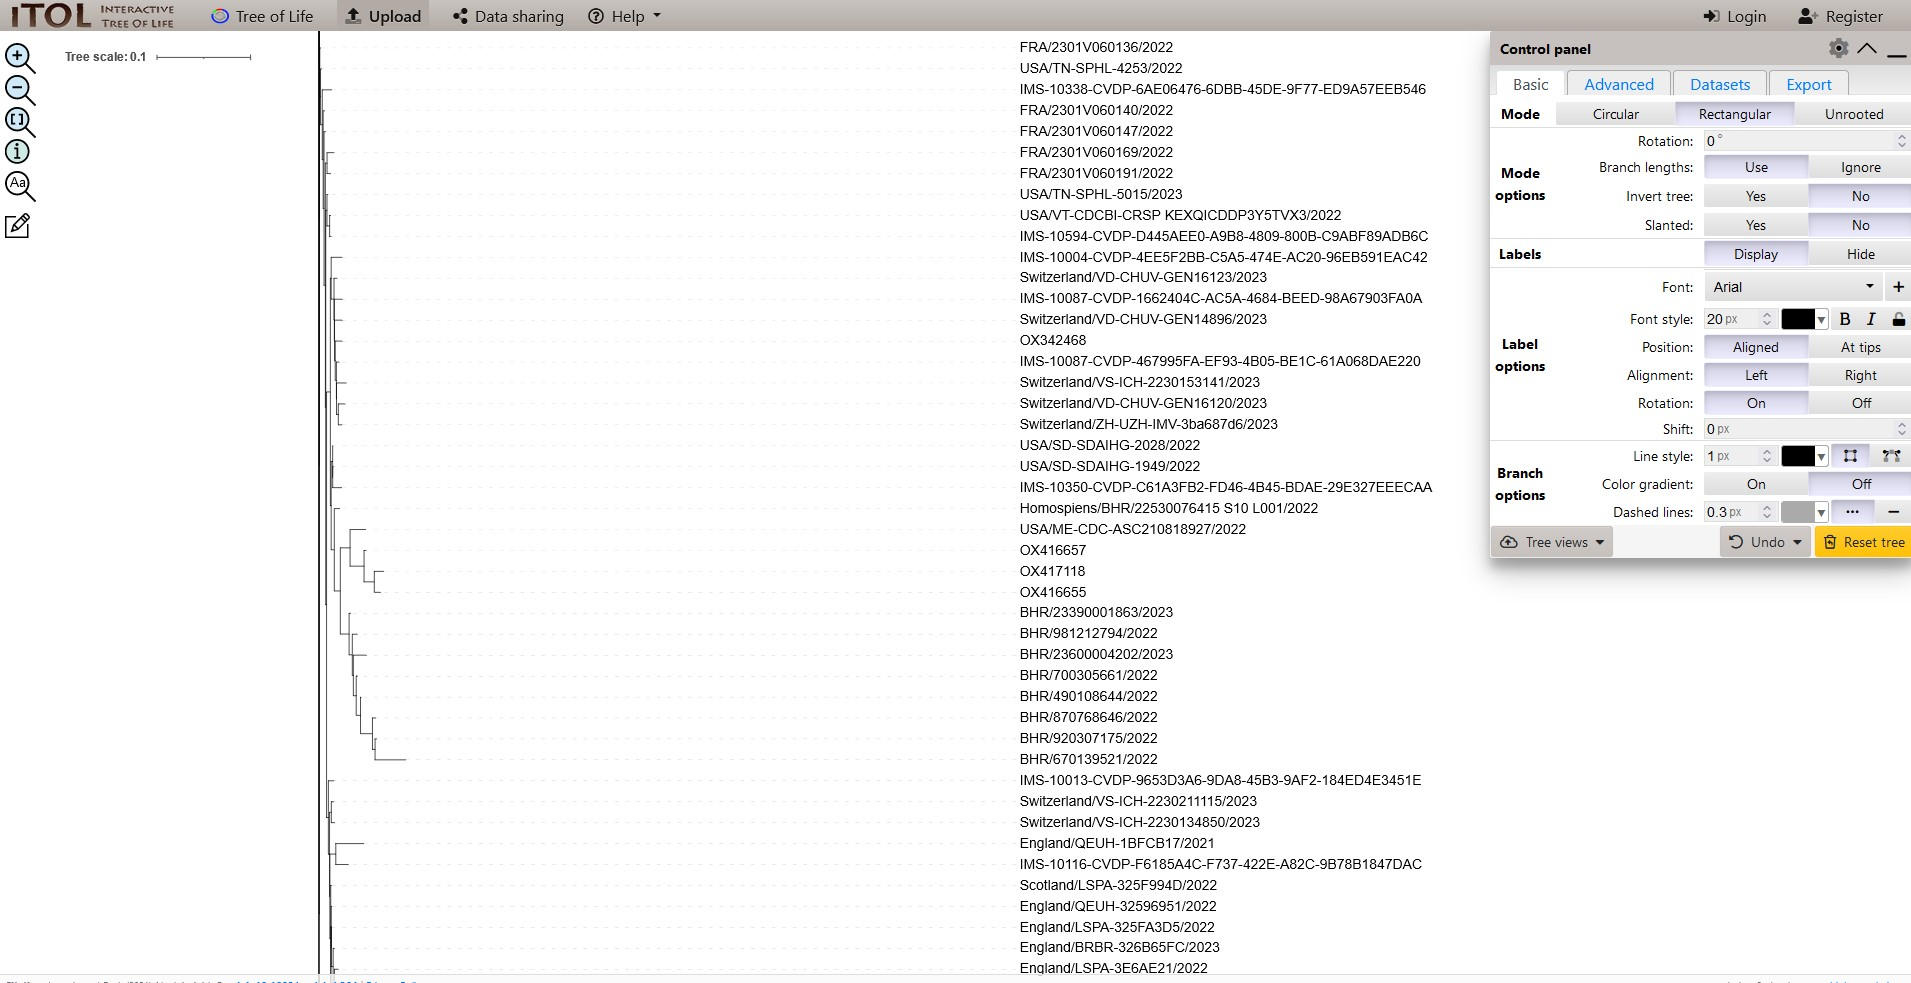

In [ ]:
import os
os.system('say "Der Skript ist zu Ende, yuuuhuuu"')

In [ ]:
os.system('say "Hast du es gehört?"')

In [ ]:
os.system('say "Ja, du. Der Skript ist fertig gelaufen!"')